In [30]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from utils import zscore, butterworth_highpass, load_config, load_surf

subjects = ['sub-INT010', 'sub-INT020']
subjects_bids = ['sub-010', 'sub-020']
story = 'carver'

cfg = load_config()
DATADIR = cfg['DATA_DIR']
STIMDIR = cfg['STIM_DIR']
FIGDIR = cfg['FIG_DIR']

tr = 1.5

MVPDIR = '/Users/gio/projects/Interruption_data/mvp/'

def load_mvp_xian(dir, subject, story):
    df = pd.read_csv(os.path.join(dir, f'{subject}_{story}_a1_mvp.csv'))
    data = np.array(df)
    return zscore(butterworth_highpass(data, tr, 0.01), axis=1)


In [31]:
da1 = []
for subject in subjects_bids:
    da1.append(load_mvp_xian(MVPDIR, subject, story))

da1 = np.array(da1)

n_trs = da1.shape[2]

In [32]:
ydata = []
for i, subject in enumerate(subjects):
    surf_data = load_surf(DATADIR, subject, story, 'L')

    surf_data = zscore(butterworth_highpass(surf_data, tr, 0.01), axis=1)

    print(surf_data.shape)

    ydata.append(surf_data)

ydata = np.array(ydata)

(40962, 736)
(40962, 736)


In [33]:
# load stimuli
from scipy.io import wavfile
STIMDIR = '/Users/gio/projects/Interruption_data/stimuli/'
audio_file_name = 'crvr_continuous.wav'

sr, audio = wavfile.read(os.path.join(STIMDIR, audio_file_name))
print(audio.shape[0] / sr)

from utils import get_envelope, lanczosinterp2D
envelope = get_envelope(audio)[:,0]

# average envelope every 0.1 seconds
window = 0.1
envelope_avg = np.mean(envelope[:len(envelope) // int(sr * window) * int(sr * window)].reshape(-1, int(sr * window)), axis=1).reshape(-1, 1)

n_trs = ydata.shape[2]
dsEnv = lanczosinterp2D(envelope_avg, np.arange(envelope_avg.shape[0]) * window, (np.arange(n_trs)) * tr)

zEnv = (dsEnv - np.mean(dsEnv)) / np.std(dsEnv)

848.9987708333333


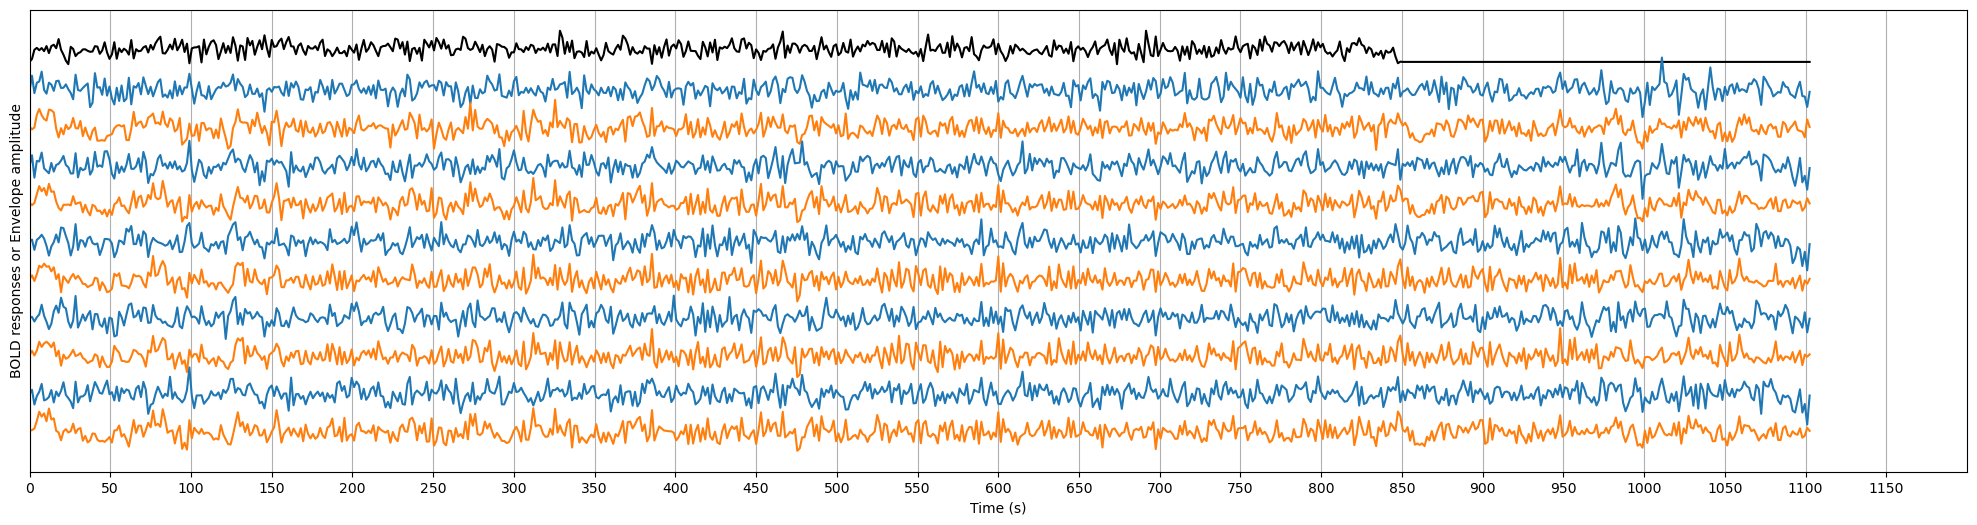

In [38]:
from matplotlib.pyplot import figure
selvoxels = [1663, 16953, 11411, 11410, 3732] #, 25149, 269, 11412, 27369, 25150]

colors = plt.cm.tab10.colors
f = figure(figsize=(25,6))
f.clf()
ax = f.add_subplot(1,1,1)
ax.plot(np.arange(zEnv.shape[0]) * tr, zEnv + 5, "k-", label="Downsampled envelope (TR)")

for i, selvoxel in enumerate(selvoxels):
    for isubj, subject in enumerate(subjects):
        ax.plot(np.arange(ydata.shape[2]) * tr, ydata[isubj][selvoxel, :] - 5 * isubj - i * 10, color=colors[isubj])

# for isubj, subject in enumerate(subjects):
#     ax.plot(np.arange(ydata.shape[0]) * tr, surf_data_all[isubj][topvoxels[1], :] - 5 * isubj - 15, color=colors[isubj])

# mean_voxel_0 = np.mean([surf_data_all[isubj][selvoxel, :] for isubj in range(len(subjects))], axis=0)
# mean_voxel_1 = np.mean([surf_data_all[isubj][topvoxels[1], :] for isubj in range(len(subjects))], axis=0)

ax.set_xlim(0, 1200)
ax.set_xticks(range(0, 1200, 50))
ax.set_yticks([])

ax.set_xlabel("Time (s)")
ax.set_ylabel("BOLD responses or Envelope amplitude")
ax.grid()



In [55]:
env = zEnv[:565, 0]
da1_trimmed = da1[:, :, 80:80 + env.shape[0]]

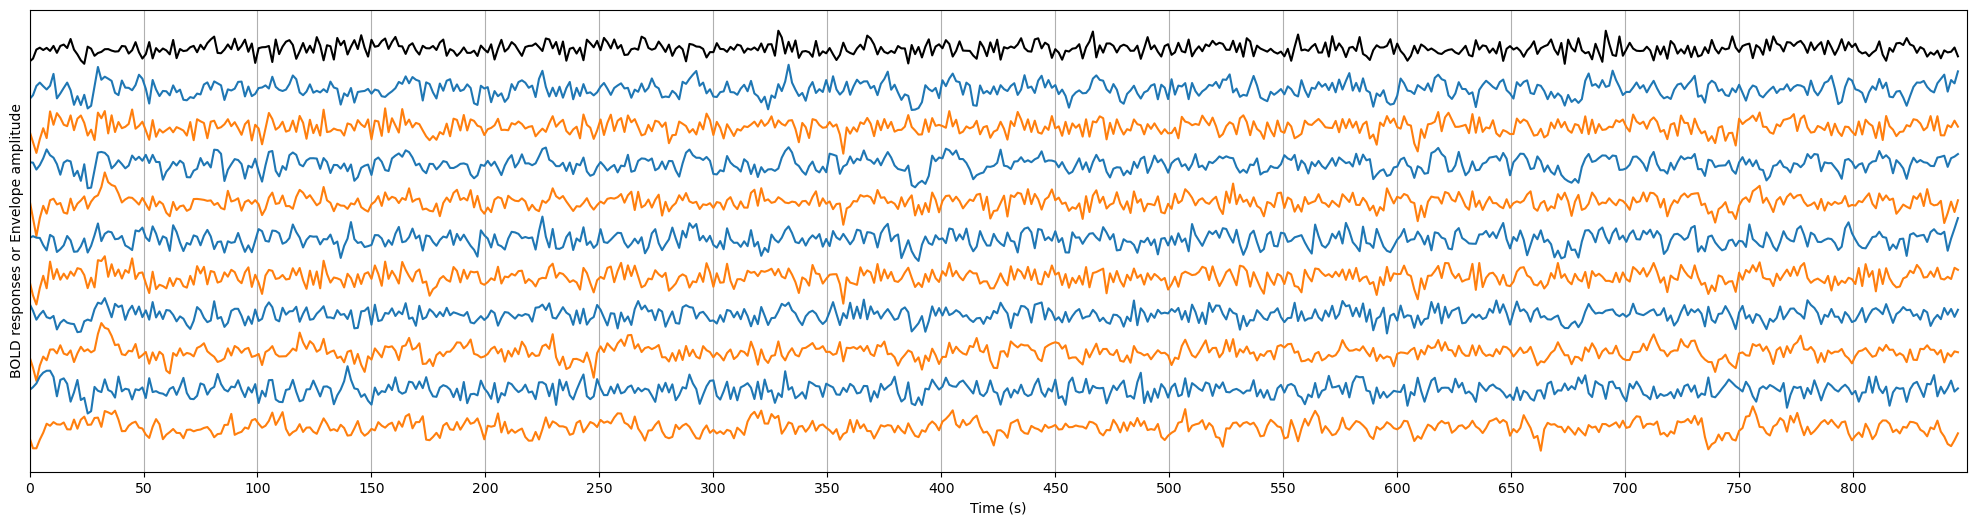

In [57]:
from matplotlib.pyplot import figure
selvoxels = np.random.choice(da1.shape[1], 5)

colors = plt.cm.tab10.colors
f = figure(figsize=(25,6))
f.clf()
ax = f.add_subplot(1,1,1)
ax.plot(np.arange(env.shape[0]) * tr, env + 5, "k-", label="Downsampled envelope (TR)")

for i, selvoxel in enumerate(selvoxels):
    for isubj, subject in enumerate(subjects):
        ax.plot(np.arange(da1_trimmed.shape[2]) * tr, da1_trimmed[isubj][selvoxel, :] - 5 * isubj - i * 10, color=colors[isubj])

# for isubj, subject in enumerate(subjects):
#     ax.plot(np.arange(ydata.shape[0]) * tr, surf_data_all[isubj][topvoxels[1], :] - 5 * isubj - 15, color=colors[isubj])

# mean_voxel_0 = np.mean([surf_data_all[isubj][selvoxel, :] for isubj in range(len(subjects))], axis=0)
# mean_voxel_1 = np.mean([surf_data_all[isubj][topvoxels[1], :] for isubj in range(len(subjects))], axis=0)

ax.set_xlim(0, 850)
ax.set_xticks(range(0, 850, 50))
ax.set_yticks([])

ax.set_xlabel("Time (s)")
ax.set_ylabel("BOLD responses or Envelope amplitude")
ax.grid()

Text(0, 0.5, 'Correlation')

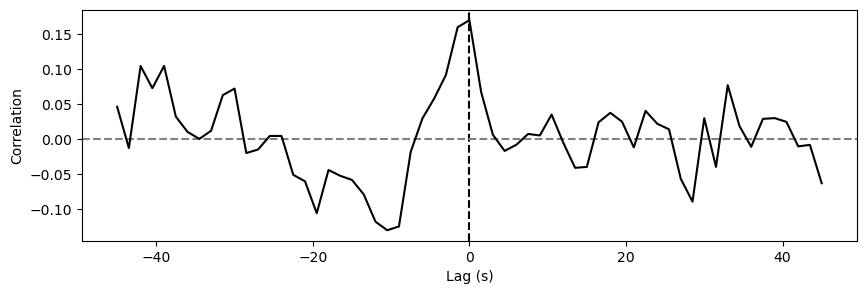

In [60]:
# compute lag cross correlation between two time series

def lagcorr(x, y, maxlag=10):
    lags = np.arange(-maxlag, maxlag + 1)
    corrs = np.zeros(lags.shape)
    for i, lag in enumerate(lags):
        if lag < 0:
            corrs[i] = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag == 0:
            corrs[i] = np.corrcoef(x, y)[0, 1]
        else:
            corrs[i] = np.corrcoef(x[lag:], y[:-lag])[0, 1]
    
    return lags, corrs

# lags, corrs = lagcorr(env, da1_trimmed[0][selvoxels[0], :], maxlag=30)
lags, corrs = lagcorr(da1_trimmed[0][selvoxels[1], :], da1_trimmed[1][selvoxels[1], :], maxlag=30)


f = figure(figsize=(10, 3))
f.clf()
ax = f.add_subplot(1,1,1)
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='gray', linestyle='--')
ax.plot(lags * tr, corrs, "k-")
ax.set_xlabel("Lag (s)")
ax.set_ylabel("Correlation")

In [62]:
ydata_trimmed = ydata[:, :, 80:80 + env.shape[0]]

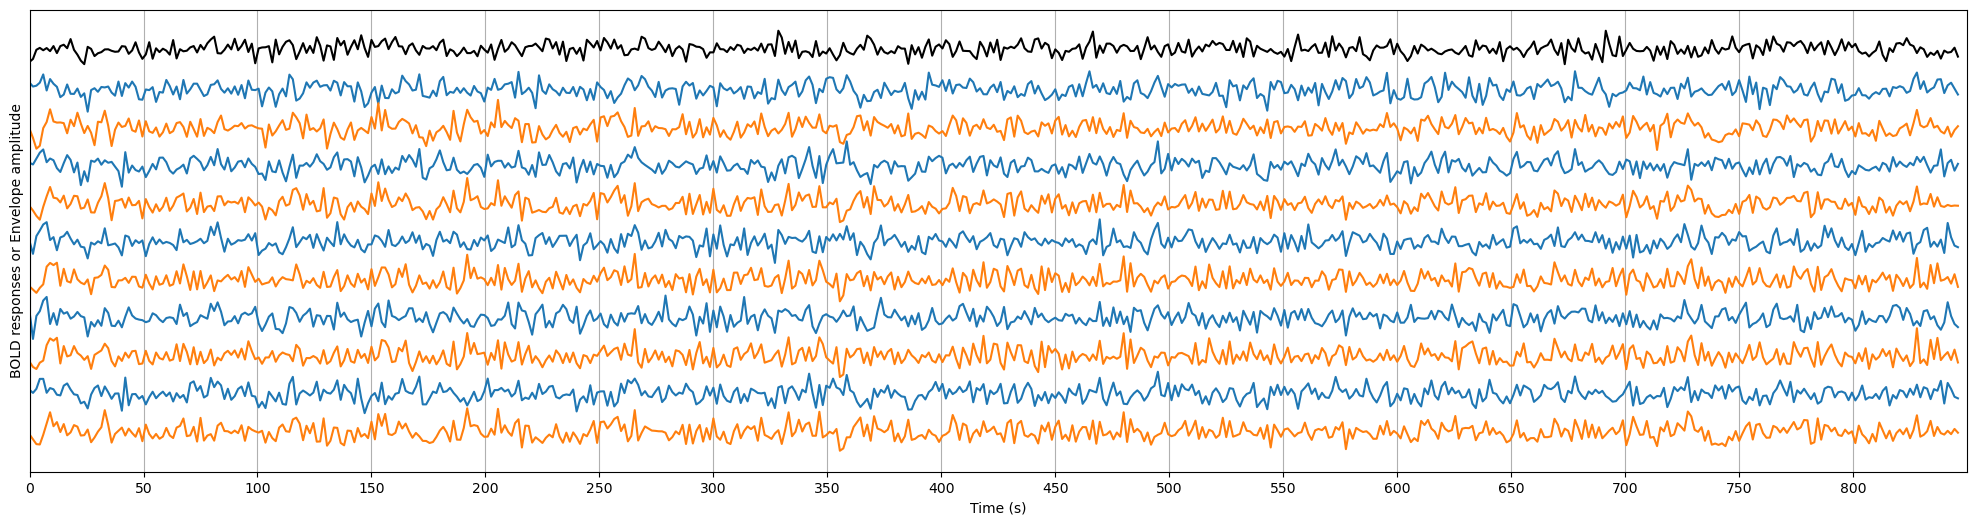

In [63]:
from matplotlib.pyplot import figure
selvoxels = [1663, 16953, 11411, 11410, 3732] #, 25149, 269, 11412, 27369, 25150]

colors = plt.cm.tab10.colors
f = figure(figsize=(25,6))
f.clf()
ax = f.add_subplot(1,1,1)
ax.plot(np.arange(env.shape[0]) * tr, env + 5, "k-", label="Downsampled envelope (TR)")

for i, selvoxel in enumerate(selvoxels):
    for isubj, subject in enumerate(subjects):
        ax.plot(np.arange(ydata_trimmed.shape[2]) * tr, ydata_trimmed[isubj][selvoxel, :] - 5 * isubj - i * 10, color=colors[isubj])

# for isubj, subject in enumerate(subjects):
#     ax.plot(np.arange(ydata.shape[0]) * tr, surf_data_all[isubj][topvoxels[1], :] - 5 * isubj - 15, color=colors[isubj])

# mean_voxel_0 = np.mean([surf_data_all[isubj][selvoxel, :] for isubj in range(len(subjects))], axis=0)
# mean_voxel_1 = np.mean([surf_data_all[isubj][topvoxels[1], :] for isubj in range(len(subjects))], axis=0)

ax.set_xlim(0, 850)
ax.set_xticks(range(0, 850, 50))
ax.set_yticks([])

ax.set_xlabel("Time (s)")
ax.set_ylabel("BOLD responses or Envelope amplitude")
ax.grid()

Text(0, 0.5, 'Correlation')

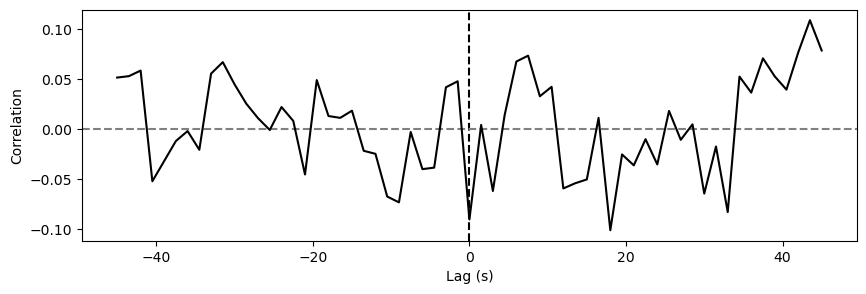

In [67]:
# compute lag cross correlation between two time series

def lagcorr(x, y, maxlag=10):
    lags = np.arange(-maxlag, maxlag + 1)
    corrs = np.zeros(lags.shape)
    for i, lag in enumerate(lags):
        if lag < 0:
            corrs[i] = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag == 0:
            corrs[i] = np.corrcoef(x, y)[0, 1]
        else:
            corrs[i] = np.corrcoef(x[lag:], y[:-lag])[0, 1]
    
    return lags, corrs

# lags, corrs = lagcorr(env, ydata_trimmed[0][selvoxels[1], :], maxlag=30)
lags, corrs = lagcorr(ydata_trimmed[0][selvoxels[1], :], da1_trimmed[0][0, :], maxlag=30)


f = figure(figsize=(10, 3))
f.clf()
ax = f.add_subplot(1,1,1)
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='gray', linestyle='--')
ax.plot(lags * tr, corrs, "k-")
ax.set_xlabel("Lag (s)")
ax.set_ylabel("Correlation")

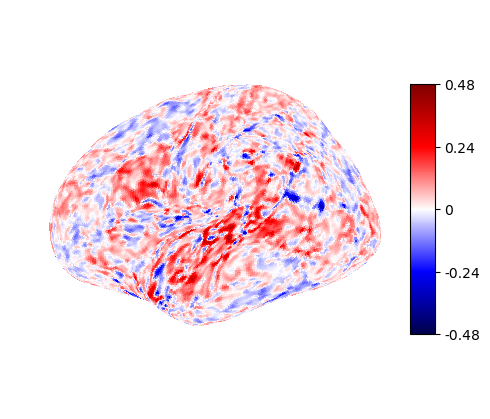

In [69]:
# find correspondance between da1 and ydata
ivoxel = 100
corrs = np.zeros(ydata_trimmed.shape[1])
for iv in range(ydata_trimmed.shape[1]):
    corrs[iv] = np.corrcoef(ydata_trimmed[0][iv, :], da1_trimmed[0][ivoxel, :])[0, 1]

# plot with plot_surf_map
from nilearn import datasets, plotting
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage6')
f = plotting.plot_surf_stat_map(fsaverage.infl_left, corrs, hemi='left', view='lateral', colorbar=True, cmap='seismic')

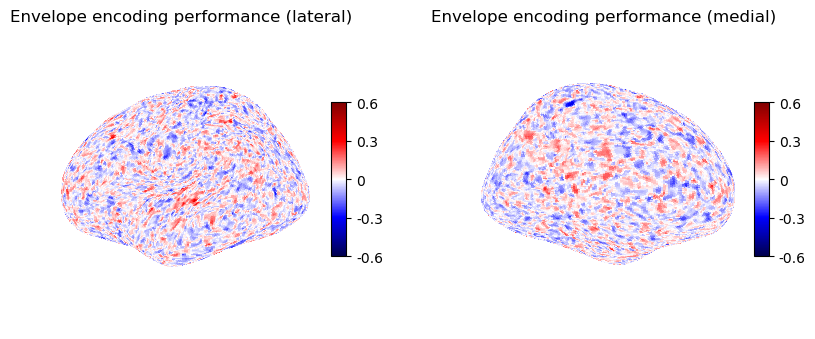

In [71]:
# envelope encoding model with ydata_trimmed
from utils import make_delayed, pearsonr
from ridge import ridge_cv

n_delays = 5 # 7.5 seconds
xdata = make_delayed(zscore(env)[:, np.newaxis], np.arange(1, n_delays + 1))

nfolds = 5

alphas = np.logspace(-3, 3, 7)

wt, corr, alphas, bscorrs, valinds, voxcorrs = ridge_cv(xdata, np.squeeze(ydata_trimmed[0, :, :]).T, alphas, nfolds)

# plot surface map

fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage6")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})

fig_l = plotting.plot_surf_stat_map(fsaverage.infl_left, voxcorrs, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.6, vmin=-0.6, axes=axes[0], title='Envelope encoding performance (lateral)')

fig_m = plotting.plot_surf_stat_map(fsaverage.infl_left, voxcorrs, hemi='left', view='medial', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.6, vmin=-0.6, axes=axes[1], title='Envelope encoding performance (medial)')

[  9   2 148  12 152  10  25   8   6  66 169  28 151   0  11 155  24  26
 133 167]
[0.44775494 0.43190063 0.41183132 0.40065148 0.39052986 0.38756815
 0.38186464 0.37950645 0.37524229 0.36756789 0.36672274 0.36644646
 0.36528303 0.35488167 0.34850719 0.34340172 0.34313585 0.34188328
 0.33572346 0.33474644]


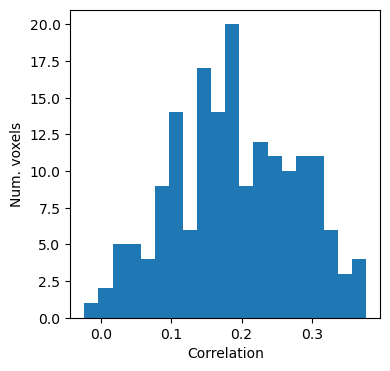

In [134]:
# envelope encoding model with da1_trimmed
from utils import make_delayed, pearsonr
from ridge import ridge_cv

n_delays = 5 # 7.5 seconds
xdata = make_delayed(zscore(env)[:, np.newaxis], np.arange(1, n_delays + 1))

nfolds = 5

alphas = np.logspace(-3, 3, 7)

n_reps = 10
voxcorrs_all = np.zeros((n_reps, da1_trimmed.shape[1]))
for i_rep in range(n_reps):
    wt, corr, bestalphas, bscorrs, valinds, voxcorrs = ridge_cv(xdata, np.squeeze(da1_trimmed[1, :, :]).T, alphas, nfolds)
    voxcorrs_all[i_rep, :] = voxcorrs

voxcorrs_mean = np.mean(voxcorrs_all, axis=0)

# Plot histogram of correlations
sorted_voxels = np.argsort(voxcorrs)[::-1]
print(sorted_voxels[:20])
print(voxcorrs[sorted_voxels[:20]])
f = figure(figsize=(4,4))
ax = f.add_subplot(1,1,1)
ax.hist(voxcorrs_mean, 20) # histogram correlations with 100 bins
ax.set_xlabel("Correlation")
ax.set_ylabel("Num. voxels")

f.savefig(os.path.join(FIGDIR, f'{subjects[1]}_enc_envelope_a1.png'))

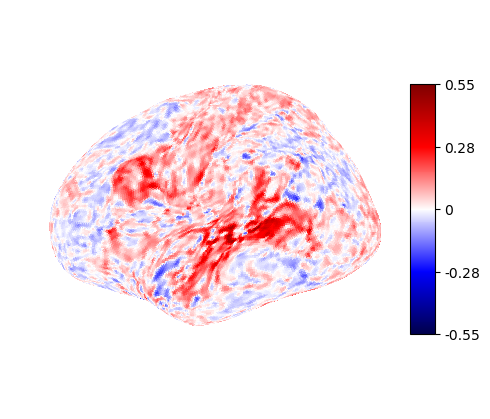

In [81]:
selvoxel = 156
# find correspondance between da1 and ydata
corrs = np.zeros(ydata_trimmed.shape[1])
for iv in range(ydata_trimmed.shape[1]):
    corrs[iv] = np.corrcoef(ydata_trimmed[0][iv, :], da1_trimmed[0][selvoxel, :])[0, 1]

# plot with plot_surf_map
from nilearn import datasets, plotting
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage6')
f = plotting.plot_surf_stat_map(fsaverage.infl_left, corrs, hemi='left', view='lateral', colorbar=True, cmap='seismic')

Text(0, 0.5, 'Correlation')

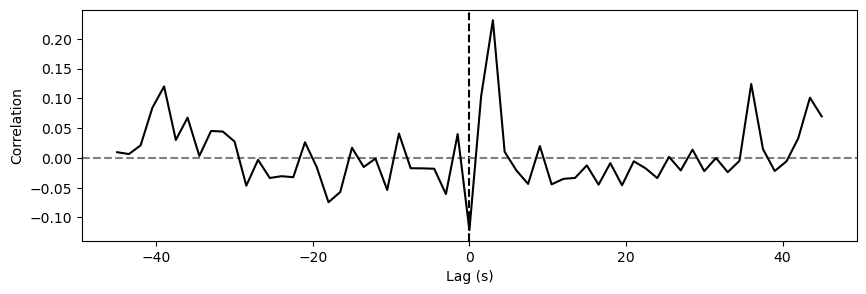

In [83]:
f1 = figure(figsize=(10, 3))
f1.clf()
ax = f1.add_subplot(1,1,1)
def lagcorr(x, y, maxlag=10):
    lags = np.arange(-maxlag, maxlag + 1)
    corrs = np.zeros(lags.shape)
    for i, lag in enumerate(lags):
        if lag < 0:
            corrs[i] = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag == 0:
            corrs[i] = np.corrcoef(x, y)[0, 1]
        else:
            corrs[i] = np.corrcoef(x[lag:], y[:-lag])[0, 1]
    
    return lags, corrs
lags, ccorrs = lagcorr(da1_trimmed[0][selvoxel, :], env, maxlag=30)

ax.axvline(0, color='k', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')
ax.plot(lags * tr, ccorrs, "k-")
ax.set_xlabel("Lag (s)")
ax.set_ylabel("Correlation")

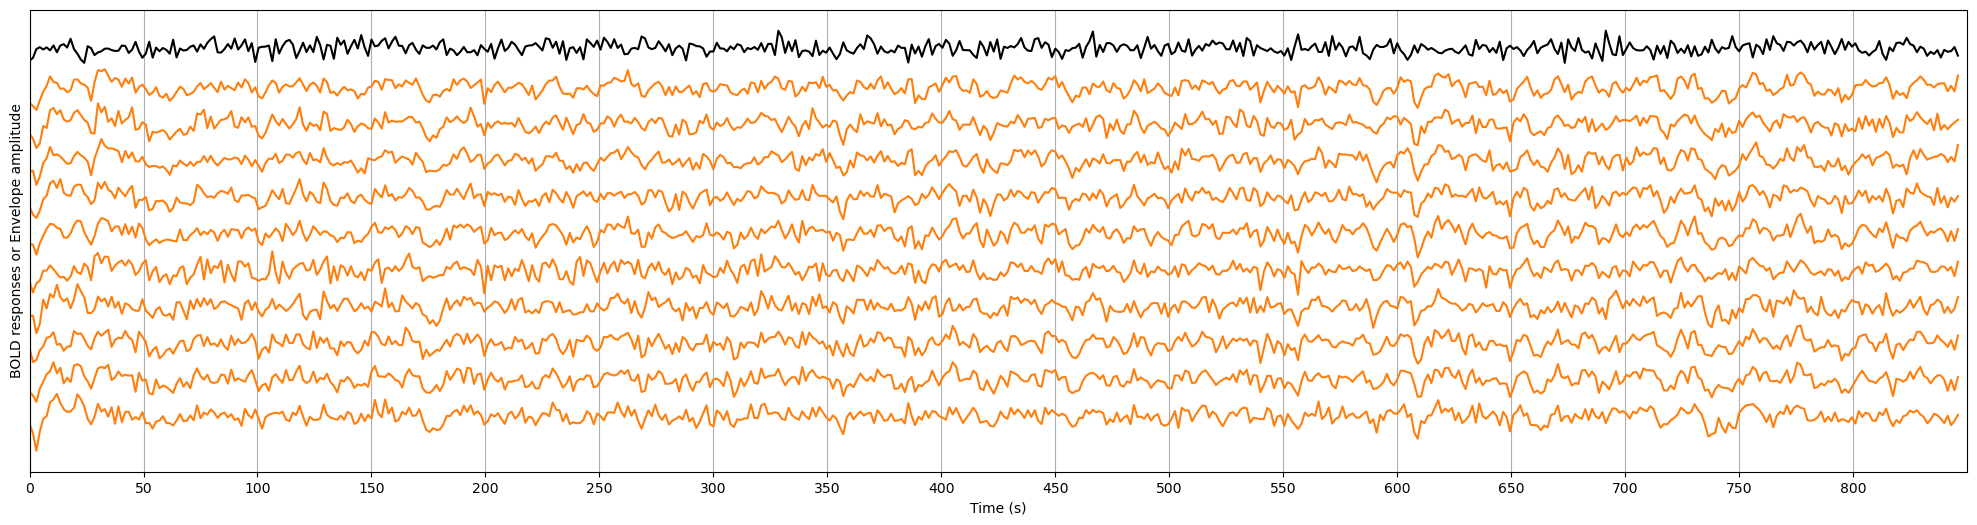

In [130]:
# plot the envelope, the selected a1 voxel, and the vertices that have high correlation with the a1 voxel
from matplotlib.pyplot import figure

colors = plt.cm.tab10.colors
f = figure(figsize=(25,6))
f.clf()
ax = f.add_subplot(1,1,1)
ax.plot(np.arange(env.shape[0]) * tr, env + 5, "k-", label="Downsampled envelope (TR)")

# ax.plot(np.arange(da1_trimmed.shape[2]) * tr, da1_trimmed[0][selvoxel, :] + 5, color=colors[0], label="Selected a1 voxel")

highcorr_voxels = np.argsort(corrs)[::-1][:10]
highenc_voxels = np.argsort(voxcorrs_mean)[::-1][:10]

for i, voxel in enumerate(highenc_voxels):
    ax.plot(np.arange(ydata_trimmed.shape[2]) * tr, ydata_trimmed[1][voxel, :] - i * 5, color=colors[1])

ax.set_xlim(0, 850)
ax.set_xticks(range(0, 850, 50))
ax.set_yticks([])

ax.set_xlabel("Time (s)")
ax.set_ylabel("BOLD responses or Envelope amplitude")
ax.grid()

f.savefig(os.path.join(FIGDIR, f'{subjects[1]}_best_enc_envelope_timecourse.png'))

In [87]:
print(corrs[highcorr_voxels])

[0.55131326 0.54204065 0.52281347 0.50935631 0.50884086 0.50389262
 0.50122416 0.49577624 0.49509286 0.49329059]


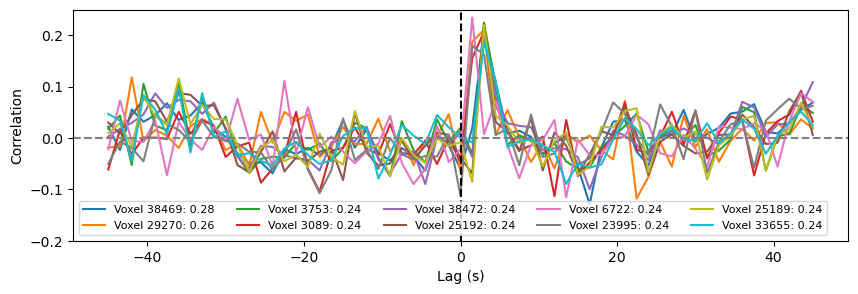

In [138]:
highenc_voxels = np.argsort(voxcorrs_mean)[::-1][:10]
f1 = figure(figsize=(10, 3))
f1.clf()
ax = f1.add_subplot(1,1,1)
def lagcorr(x, y, maxlag=10):
    lags = np.arange(-maxlag, maxlag + 1)
    corrs = np.zeros(lags.shape)
    for i, lag in enumerate(lags):
        if lag < 0:
            corrs[i] = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag == 0:
            corrs[i] = np.corrcoef(x, y)[0, 1]
        else:
            corrs[i] = np.corrcoef(x[lag:], y[:-lag])[0, 1]
    
    return lags, corrs

for i, voxel in enumerate(highenc_voxels):
    lags, ccorrs = lagcorr(ydata_trimmed[0][voxel, :], env, maxlag=30)
    ax.plot(lags * tr, ccorrs, label=f"Voxel {voxel}: {voxcorrs_mean[voxel]:.2f}")

ax.axvline(0, color='k', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel("Lag (s)")
ax.set_ylabel("Correlation")
ax.set_ylim(-0.2, 0.25)
ax.legend(ncol=5, prop={'size': 8})

f1.savefig(os.path.join(FIGDIR, f'{subjects[0]}_crosscorr_envelope.png'))


In [135]:
# envelope encoding model with da1_trimmed
from utils import make_delayed, pearsonr, get_logger
from ridge import ridge_cv
import time

logging = get_logger()

n_delays = 5 # 7.5 seconds
xdata = make_delayed(zscore(env)[:, np.newaxis], np.arange(1, n_delays + 1))

nfolds = 5

alphas = np.logspace(-3, 3, 7)

n_reps = 10

voxcorrs_all = np.zeros((n_reps, ydata_trimmed.shape[1]))

for irep in range(n_reps):
    wt, corr, _, bscorrs, valinds, voxcorrs = ridge_cv(xdata, np.squeeze(ydata_trimmed[0, :, :]).T, alphas, nfolds)
    logging.info(f"Repetition {irep}: current time: {time.ctime()}")
    voxcorrs_all[irep, :] = voxcorrs

voxcorrs_mean = np.mean(voxcorrs_all, axis=0)


[INFO] utils.<module> - Repetition 0: current time: Thu Nov 21 09:48:18 2024
[INFO] utils.<module> - Repetition 1: current time: Thu Nov 21 09:48:27 2024
[INFO] utils.<module> - Repetition 2: current time: Thu Nov 21 09:48:34 2024
[INFO] utils.<module> - Repetition 3: current time: Thu Nov 21 09:48:41 2024
[INFO] utils.<module> - Repetition 4: current time: Thu Nov 21 09:48:49 2024
[INFO] utils.<module> - Repetition 5: current time: Thu Nov 21 09:48:58 2024
[INFO] utils.<module> - Repetition 6: current time: Thu Nov 21 09:49:05 2024
[INFO] utils.<module> - Repetition 7: current time: Thu Nov 21 09:49:13 2024
[INFO] utils.<module> - Repetition 8: current time: Thu Nov 21 09:49:21 2024
[INFO] utils.<module> - Repetition 9: current time: Thu Nov 21 09:49:28 2024


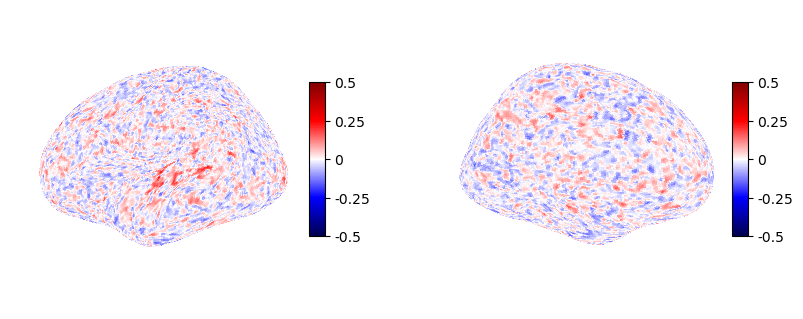

In [121]:
# plot surface map
fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})
fl = plotting.plot_surf_stat_map(fsaverage.infl_left, voxcorrs_mean, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.5, vmin=-0.5, axes=axes[0])
fm = plotting.plot_surf_stat_map(fsaverage.infl_left, voxcorrs_mean, hemi='left', view='medial', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.5, vmin=-0.5, axes=axes[1])

fig.savefig(os.path.join(FIGDIR, f'{subjects[0]}_{story}_enc_envelope.png'))

86
56
35
161
98
69
27
107
83
0


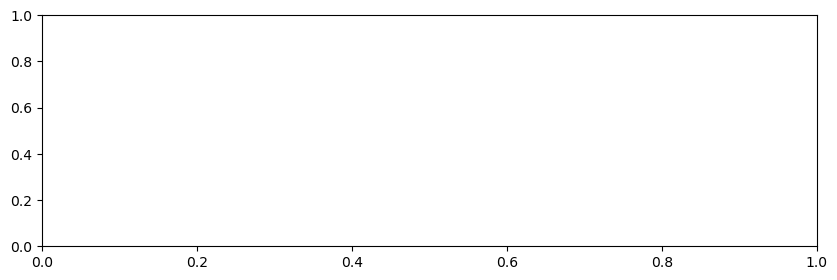

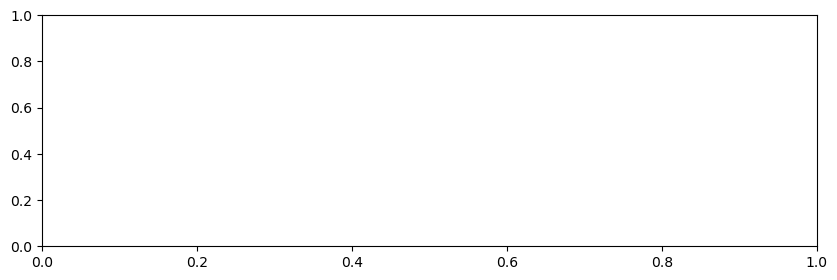

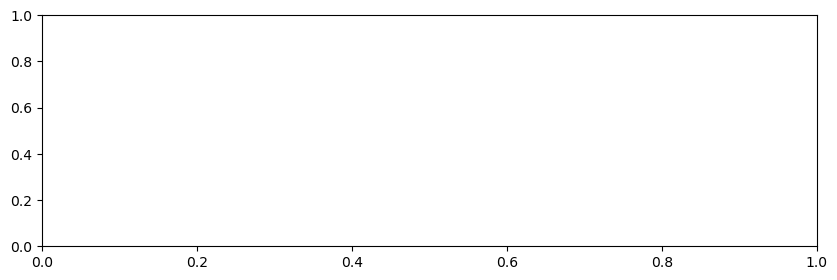

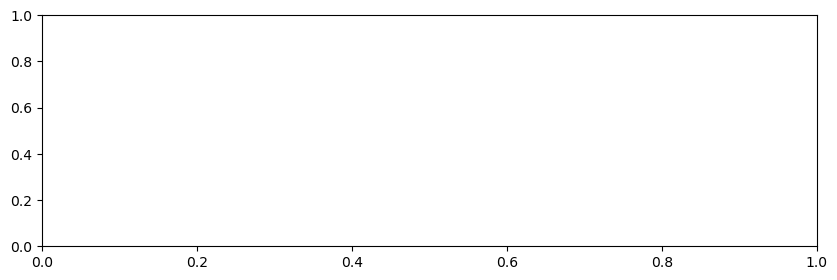

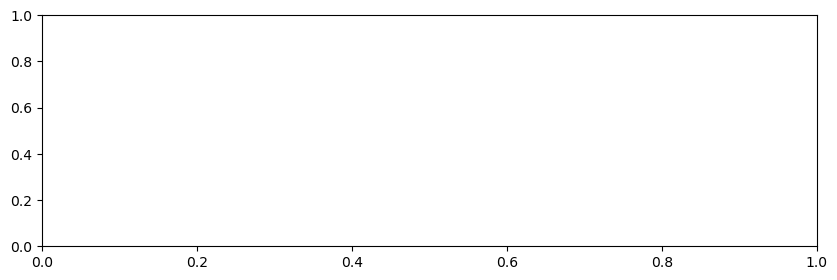

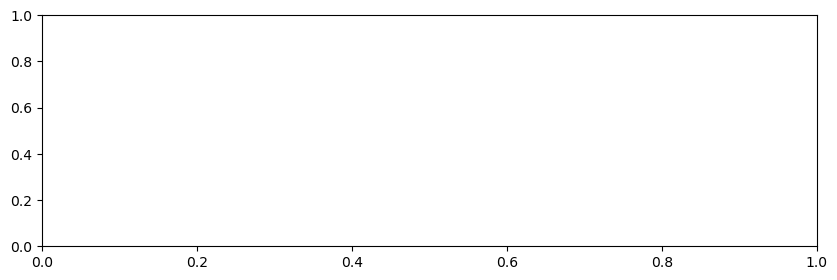

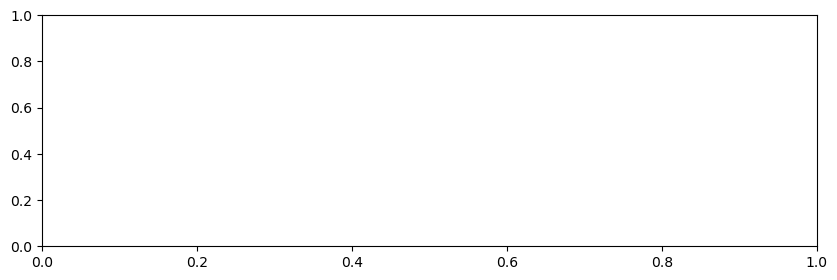

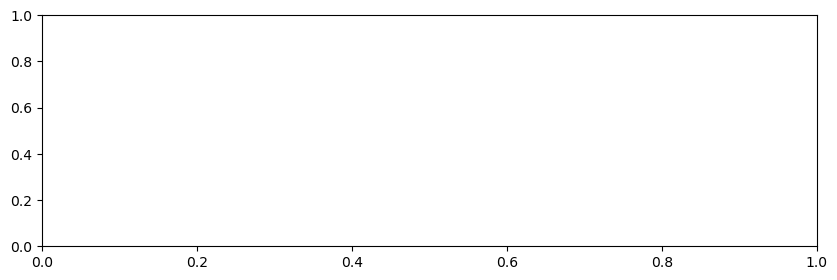

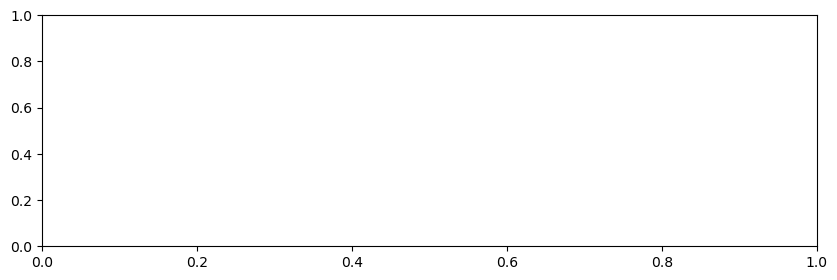

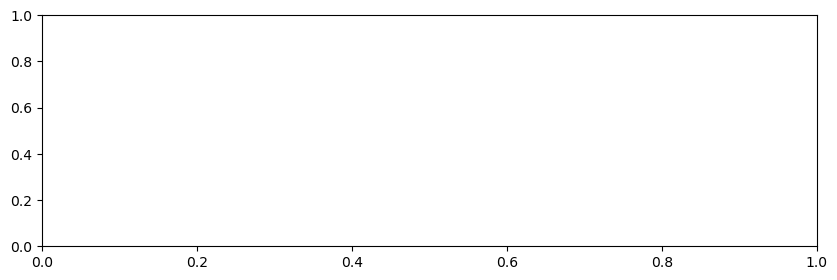

In [49]:
# time-shifted correlation
env = zEnv[:566, 0]

ax = f.add_subplot(1,1,1)
for isubj, subject in enumerate(subjects):
    for i, selvoxel in enumerate(selvoxels):
        f = figure(figsize=(10, 3))
        ax = f.add_subplot(1,1,1)
        corr = [np.corrcoef(env, ydata[isubj][selvoxel, i:i+566])[0,1] for i in range(ydata.shape[2] - 566)]
        ax.plot(np.arange(len(corr)) * tr, np.array(corr), color=colors[isubj])
        # print(np.argmax(corr))

82
82
104
54
82
128
0
82
82
82


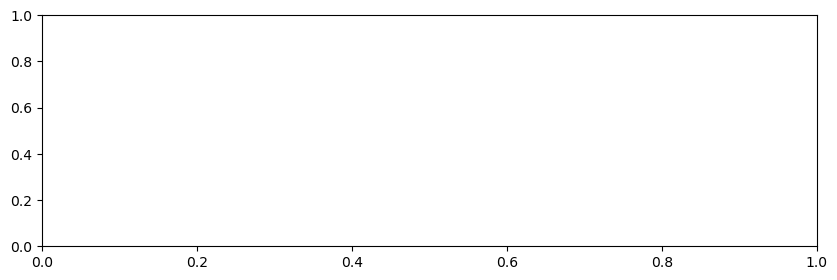

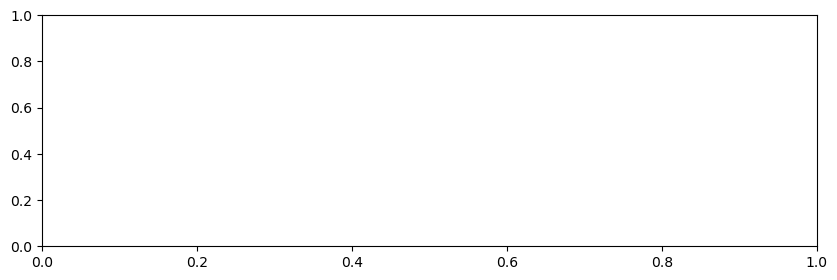

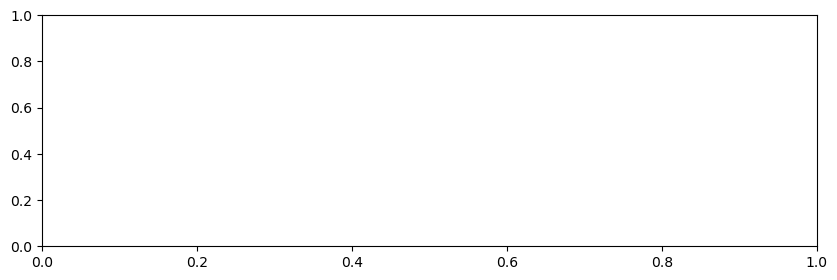

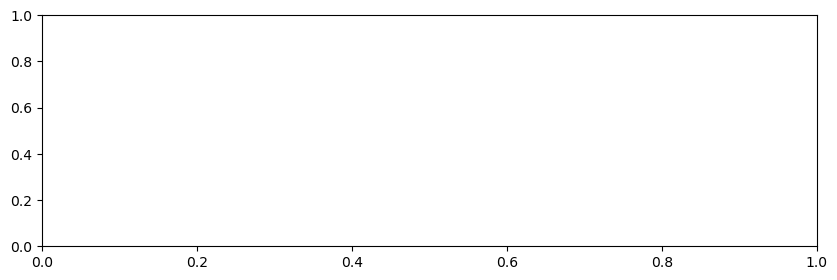

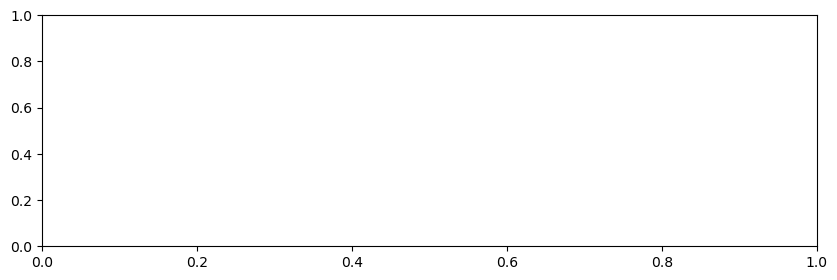

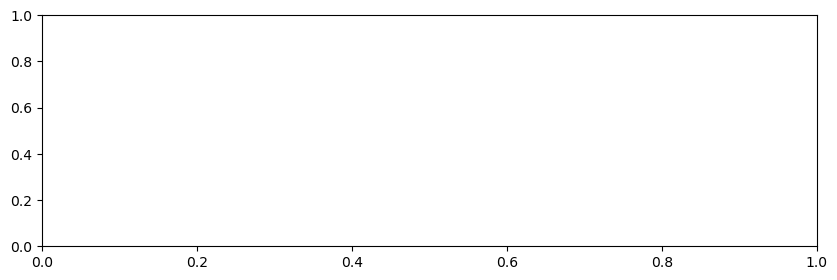

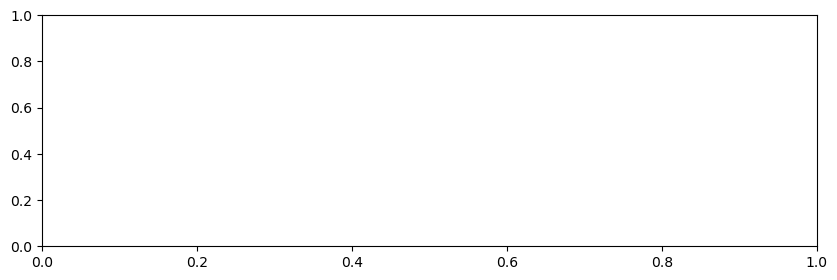

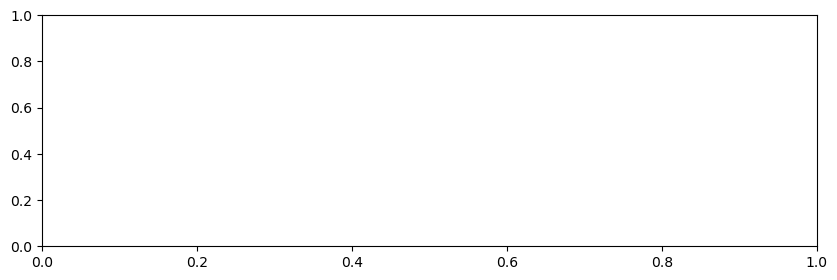

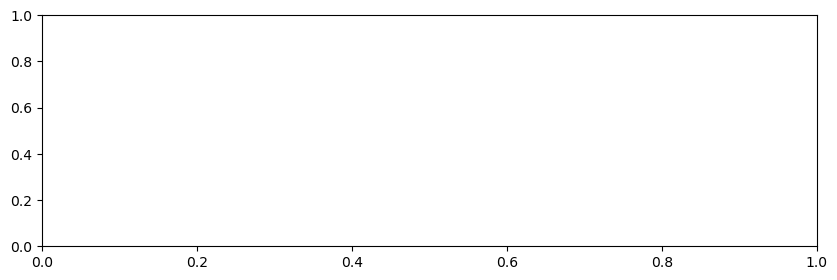

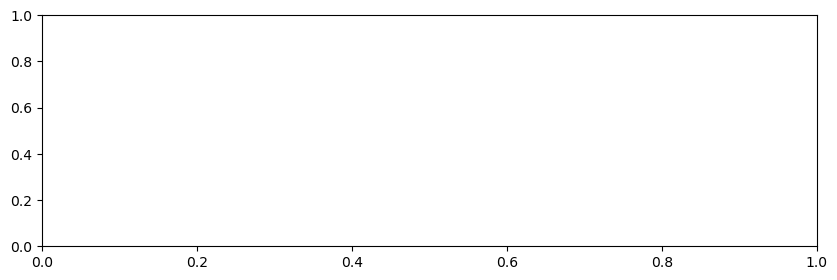

In [48]:
# time-shifted correlation
env = zEnv[:566, 0]
selvoxels = [100, 20, 30, 10, 70]

ax = f.add_subplot(1,1,1)
for isubj, subject in enumerate(subjects):
    for i, selvoxel in enumerate(selvoxels):
        f = figure(figsize=(10, 3))
        ax = f.add_subplot(1,1,1)
        corr = [np.corrcoef(env, da1[isubj][selvoxel, i:i+566])[0,1] for i in range(da1.shape[2] - 566)]
        ax.plot(np.arange(len(corr)) * tr, np.array(corr), color=colors[isubj])
        # print(np.argmax(corr))

Text(0, 0.5, 'Correlation')

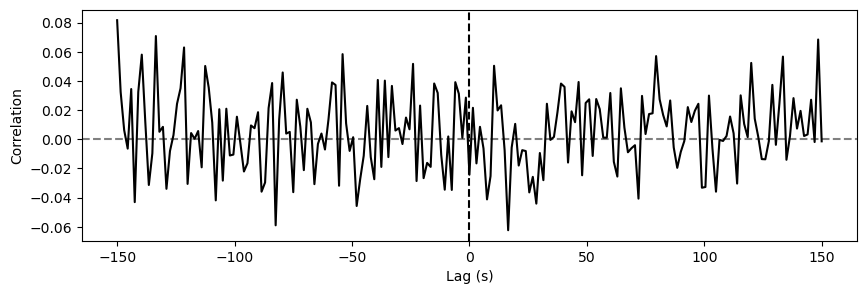

In [35]:
# compute lag cross correlation between two time series

def lagcorr(x, y, maxlag=10):
    lags = np.arange(-maxlag, maxlag + 1)
    corrs = np.zeros(lags.shape)
    for i, lag in enumerate(lags):
        if lag < 0:
            corrs[i] = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag == 0:
            corrs[i] = np.corrcoef(x, y)[0, 1]
        else:
            corrs[i] = np.corrcoef(x[lag:], y[:-lag])[0, 1]
    
    return lags, corrs

lags, corrs = lagcorr(zEnv.flatten()[:850], ydata[0][selvoxels[0], :850], maxlag=100)
# lags, corrs = lagcorr(ydata[0][selvoxels[0], :850], ydata[1][selvoxels[0], :850], maxlag=30)


f = figure(figsize=(10, 3))
f.clf()
ax = f.add_subplot(1,1,1)
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='gray', linestyle='--')
ax.plot(lags * tr, corrs, "k-")
ax.set_xlabel("Lag (s)")
ax.set_ylabel("Correlation")

In [36]:
# Calculate the inter-subject correlation between BOLD responses and the correlation between BOLD signal and audio envelope for each voxel
iscs_all = np.zeros((ydata.shape[1], len(subjects) * (len(subjects) - 1) // 2))
for ivoxel in range(ydata.shape[1]):
    surf_data_subject = np.squeeze(ydata[:, ivoxel, :])
    isc_mat = np.corrcoef(surf_data_subject)
    iscs_voxel = [isc_mat[i, j] for i in range(len(subjects)) for j in range(i + 1, len(subjects))]
    iscs_all[ivoxel] = iscs_voxel

isc_mean = np.mean(iscs_all, axis=1)


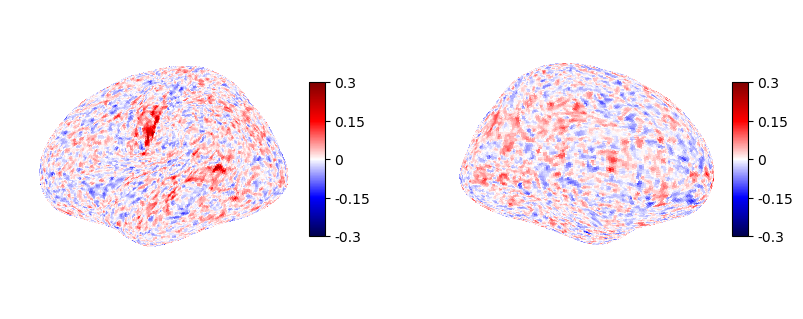

In [117]:
from nilearn import datasets, plotting
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage6')

fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})

# plot isc
f_isc_l = plotting.plot_surf_stat_map(fsaverage.infl_left, isc_mean, hemi='left', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, axes=axes[0])
f_isc_m = plotting.plot_surf_stat_map(fsaverage.infl_left, isc_mean, hemi='left', view='medial', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, axes=axes[1])
fig.savefig(os.path.join(FIGDIR, f'{subjects[0]}_{subjects[1]}_{story}_isc.png'))
